# Required imports

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset import

In [11]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        #df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(32, 16)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

# Reshaping and image like display

In [22]:
image_size = [32,16]  # Height / width of the square images
batch_size = 1   

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="penultimate.csv", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

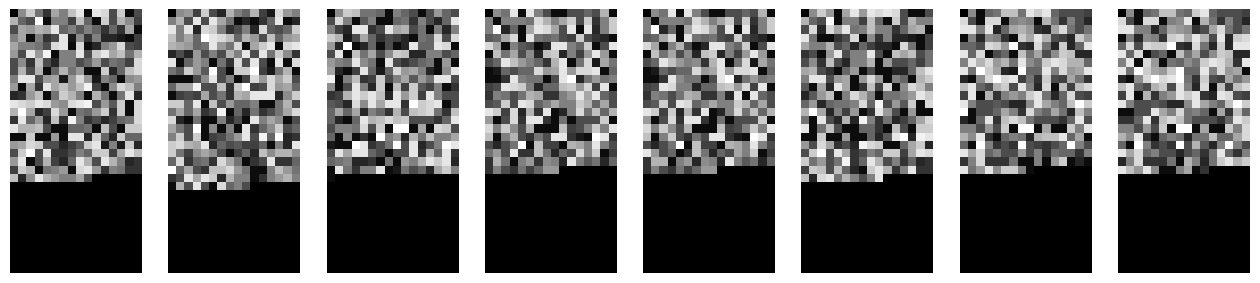

In [23]:
plt.figure(figsize=(16,32))
indices = np.random.randint(16707,size=8)
for i in range(8):
    
    image = dataset[indices[i]][0].reshape(image_size[0],image_size[1])
    plt.subplot(1,8,(i+1))
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [24]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size[0] * image_size[1],64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
      #print(x.size())
      return self.model(x)

# Quantum Circuit parameters

In [25]:
#Test cell
n_qubits = 9  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 8 # Depth of the parameterised quantum circuit / D
n_generators = 2 # Number of subgenerators for the patch method / N_G

In [26]:
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)
   # weights = weights.reshape(2*q_depth, n_qubits)

    # Initialise latent vectors
    
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)
        for y in range(n_qubits):
            qml.RX(weights[i][y], wires=y)
            qml.RZ(weights[i][y], wires=y)
        # Control Z gates
        # 
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)
    #drawer = qml.draw(probs)
    #print(drawer)
    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven



# Quantum Generator

In [28]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)
        

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

# Training

In [29]:
lrG = 0.005  # Learning rate for the generator
lrD = 0.001  # Learning rate for the discriminator
num_iter = 200  # Number of training iterations

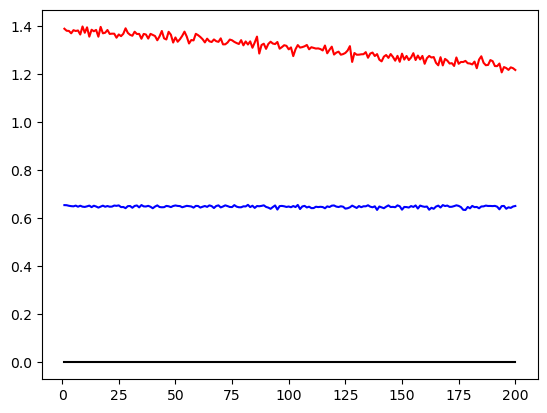

Iteration: 200, Discriminator Loss: 1.217, Generator Loss: 0.651
Iteration: 200, Discriminator Loss: 1.217, Generator Loss: 0.651


In [34]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)
from IPython.display import clear_output

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(16, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []
discerr = []
gen_err = []
countit = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size[0] * image_size[1])
        
        #print("position 1",data.shape)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size,n_qubits, device=device) * math.pi / 2
        
        #print("noise",noise.size())
        fake_data = generator(noise)
        #fake_data.reshape(1,image_size*image_size,)
        #print("fake data 1",fake_data.size())

        #print(fake_data.size())

        

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        #print(outD_real)
        #print(fake_data.size())
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1
        discerr = discerr + [errD.cpu().detach().numpy()]
        gen_err = gen_err + [errG.cpu().detach().numpy()]
        countit = countit + [counter]
        clear_output(wait=True)
        plt.plot(np.array(countit),np.array(discerr),'-r')
        plt.plot(np.array(countit),np.array(gen_err),'-b')
        plt.plot(np.array(countit),0*np.array(countit),'-k')
        plt.show()
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        # Save images every 50 iterations
        if counter % 50 == 0:
        # Show loss values
            
            test_images = generator(fixed_noise).view(16,1,image_size[0],image_size[1]).cpu().detach()
                
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            results.append(test_images)
                

        if counter == num_iter:
            break
    if counter == num_iter:
        break
        

Learning rate for the generator     =  0.005
Learning rate for the discriminator =  0.001
Number of training iterations       =  200
Batch size                          =  1
q_depth                             =  8


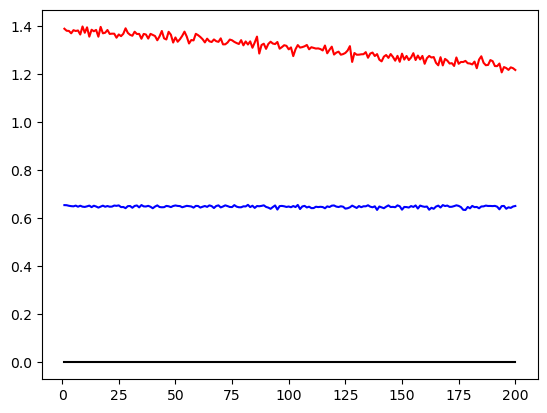

red - disc_loss && blue - gen_loss
Iteration: 200, Discriminator Loss: 1.217, Generator Loss: 0.651


In [35]:
print('Learning rate for the generator     = ',lrG)
print('Learning rate for the discriminator = ',lrD)
print('Number of training iterations       = ',num_iter)
print('Batch size                          = ',batch_size)
print('q_depth                             = ',q_depth)
#"""
plt.plot(np.array(countit),np.array(discerr),'-r')
plt.plot(np.array(countit),np.array(gen_err),'-b')
plt.plot(np.array(countit),0*np.array(countit),'-k')
plt.show()
print('red - disc_loss && blue - gen_loss')
print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
#"""

# Post Processing

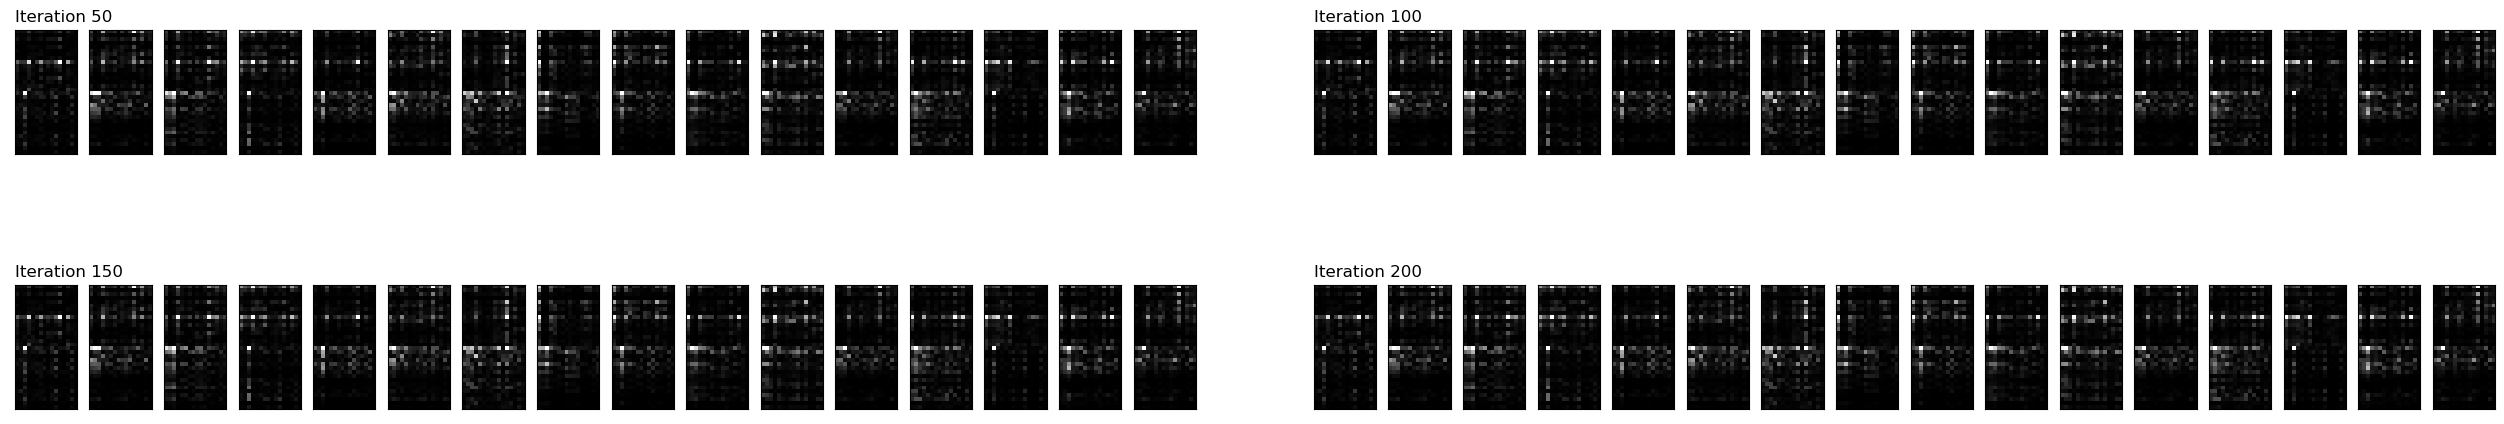

In [39]:
fig = plt.figure(figsize=(32, 16))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

In [43]:
list0 = []
for i in range(16):
    a = test_images[i][0].numpy()
    b = np.reshape(a,(512))
    b = (b - np.min(b))/np.max(b)
    b = 20*b
    for j in range(len(b)):
        b[j] = int(b[j])
    list0 = list0 + [b]

lst = np.array(list0)

# Back conversion to sequences

In [ ]:
ID_TO_AMINO_ACID = {0: '0',
                    1: 'A',
                    2: 'C',
                    3: 'D',
                    4: 'E',
                    5: 'F',
                    6: 'G',
                    7: 'H',
                    8: 'I',
                    9: 'K',
                    10: 'L',
                    11: 'M',
                    12: 'N',
                    13: 'P',
                    14: 'Q',
                    15: 'R',
                    16: 'S',
                    17: 'T',
                    18: 'V',
                    19: 'W',
                    20: 'Y'}

In [41]:
import pandas as pd
s = pd.DataFrame(lst)
s.to_csv('data001.csv')

In [17]:
import pandas as pd
import numpy as np
s = pd.read_csv("data001.csv")

In [24]:
ss = s.to_numpy()
for i in range(10):
    seq0 = ss[i]
    seq0 = (seq0 - np.min(seq0))/(np.max(seq0) - np.min(seq0))
    seq0 = 20*seq0
    for j in range(len(seq0)):
        seq0[j] = int(seq0[j])
        ss[i] = seq0
df = pd.DataFrame(ss)

In [25]:
seq = ''
ds = []
for i in range(10):
  for j in range(512):
    seq = seq + ID_TO_AMINO_ACID[df.iloc[i][j]]
  ds = ds + [seq]
  seq = ''
    
pd.DataFrame(ds).to_csv('gen_seq.csv')